<a href="https://colab.research.google.com/github/WebberMark02/machine-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo le librerie necessarie e scelgo di utilizzare "tensorflow" come
backend per "Keras".

In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from matplotlib import pyplot as plt
import sklearn
from tensorflow.keras.datasets import mnist, fashion_mnist

Imposto le variabili globali.

In [2]:
seed = 142
training_set_size = 160000
testing_set_size = 5000
validation_set_size = 20000
image_shape = (32, 32, 1)
batch_size = 2048
epochs = 15
learning_rate = 0.01
early_stopping_patience = 50
reduce_lr_patience = 5
l1_l2 = 1e-3

Definisco il generatore di immagini sulle quali il modello
verrà addestrato e testato.  
Il generatore restituisce "batchsize" immagini; ogni immagine è
la media di due immagini scelte casualmente rispettivamente da 'x1' e 'x2'.  
Il generatore restituisce, inoltre, per ogni media di immagini, la coppia delle immagini delle quali è stata calcolata la media stessa.

In [3]:
def datagenerator(x1, x2, batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Definisco una funzione per il controllo del bilanciamento delle classi.  
Mi servirà per verificare che la divisione stratificata abbia avuto successo.

In [4]:
def stampa_percentuale(y, title = ""):
  if title:
    print(title)
  # Calcolo le occorrenze di ciascuna classe nel dataset.
  unique, counts = np.unique(y, return_counts = True)
  # Calcolo la % di occorrenze per ciascuna classe.
  percentuali = (counts / len(y)) * 100
  # Stampo le occorrenze e le percentuali.
  for classe, conteggio, percentuale in zip(unique, counts, percentuali):
      print(f"Classe {classe}: Occorrenze = {conteggio}, Percentuale {percentuale} %" )
  print(f"Totale occorrenze : {sum(counts)}")
  print()

Definisco un modello banale.
Mi servirà per valutare che la rete abbia prestazioni migliori di esso.

In [5]:
def ide_model(x):
   return((x,x))

Ora ha inizio la fase di caricamento e preparazione dei dataset che verranno utilizzati
per addestrare e esaminare le prestazioni della rete.

Prima di tutto, carico i training set e i testing set di "MNIST" e "Fashion MNIST".

In [6]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

print(np.shape(mnist_x_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


Ridimensiono le immagini tramite padding, portando la loro risoluzione da 28x28 a 32x32.  
Inoltre, le normalizzo nell'intervallo [0, 1].

In [7]:
#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

print(np.shape(mnist_x_train))

(60000, 32, 32)


Aggiungo una dimensione agli array numpy delle immagini (non modifico affatto
le immagini).  
Mi serve per rendere le immagini compatibili con le dimensioni
del layer di input della rete neurale.

In [8]:
print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

mnist_x_train = np.reshape(mnist_x_train, (mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2], 1))
mnist_x_test = np.reshape(mnist_x_test, (mnist_x_test.shape[0], mnist_x_test.shape[1], mnist_x_test.shape[2], 1))
fashion_mnist_x_train = np.reshape(fashion_mnist_x_train, (fashion_mnist_x_train.shape[0], fashion_mnist_x_train.shape[1], fashion_mnist_x_train.shape[2], 1))
fashion_mnist_x_test = np.reshape(fashion_mnist_x_test, (fashion_mnist_x_test.shape[0], fashion_mnist_x_test.shape[1], fashion_mnist_x_test.shape[2], 1))

print(np.shape(mnist_x_train))
print(np.shape(mnist_x_test))
print(np.shape(fashion_mnist_x_train))
print(np.shape(fashion_mnist_x_test))

(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32)
(10000, 32, 32)
(60000, 32, 32, 1)
(10000, 32, 32, 1)
(60000, 32, 32, 1)
(10000, 32, 32, 1)


Visualizzo qualche immagine per accertarmi che l'operazione di reshaping non le abbia modificate.

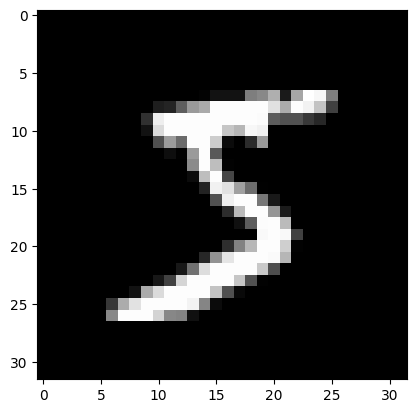

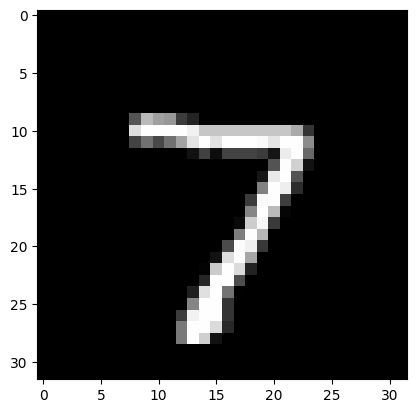

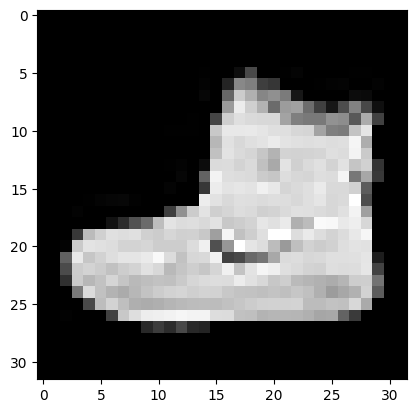

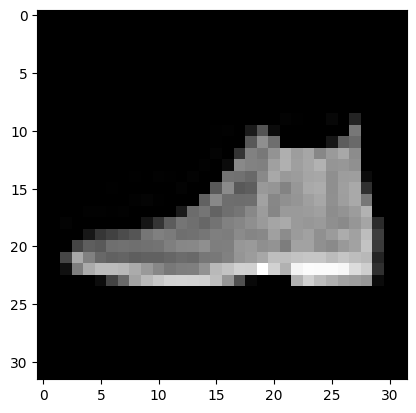

(32, 32, 1)


In [9]:
plt.imshow(mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(mnist_x_test[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_train[0], cmap='gray')
plt.show()
plt.imshow(fashion_mnist_x_test[0], cmap='gray')
plt.show()

print(mnist_x_train[0].shape)

Controllo il bilanciamento delle classi nei training set prima della divisione stratificata.

In [10]:
stampa_percentuale(mnist_y_train, 'MNIST training set completo')
stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set completo')

MNIST training set completo
Classe 0: Occorrenze = 5923, Percentuale 9.871666666666666 %
Classe 1: Occorrenze = 6742, Percentuale 11.236666666666666 %
Classe 2: Occorrenze = 5958, Percentuale 9.93 %
Classe 3: Occorrenze = 6131, Percentuale 10.218333333333334 %
Classe 4: Occorrenze = 5842, Percentuale 9.736666666666666 %
Classe 5: Occorrenze = 5421, Percentuale 9.035 %
Classe 6: Occorrenze = 5918, Percentuale 9.863333333333333 %
Classe 7: Occorrenze = 6265, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 5851, Percentuale 9.751666666666667 %
Classe 9: Occorrenze = 5949, Percentuale 9.915000000000001 %
Totale occorrenze : 60000

Fashion MNIST training set completo
Classe 0: Occorrenze = 6000, Percentuale 10.0 %
Classe 1: Occorrenze = 6000, Percentuale 10.0 %
Classe 2: Occorrenze = 6000, Percentuale 10.0 %
Classe 3: Occorrenze = 6000, Percentuale 10.0 %
Classe 4: Occorrenze = 6000, Percentuale 10.0 %
Classe 5: Occorrenze = 6000, Percentuale 10.0 %
Classe 6: Occorrenze = 6000, Perc

Divido ogni training set in due insiemi: il training set e il validation set.
Le immagini dei validation set verranno usate per l'ottimizzazione degli iper-parametri della rete.
Ogni validation set conterrà il 20% delle immagini del training set di partenza.
Uso la stratificazione per mantenere le classi nelle stesse proporzioni.

In [11]:
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = sklearn.model_selection.train_test_split(mnist_x_train, mnist_y_train, test_size=0.2, stratify=mnist_y_train, random_state=seed)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = sklearn.model_selection.train_test_split(fashion_mnist_x_train, fashion_mnist_y_train, test_size=0.2, stratify=fashion_mnist_y_train, random_state=seed)

Controllo il bilanciamento delle classi nei training set e nei validation set ottenuti dalla divisione stratificata.

In [12]:
stampa_percentuale(mnist_y_train, 'MNIST training set risultante')
stampa_percentuale(mnist_y_val, 'MNIST validation set risultante')

stampa_percentuale(fashion_mnist_y_train, 'Fashion MNIST training set risultante')
stampa_percentuale(fashion_mnist_y_val, 'Fashion MNIST validation set risultante')

MNIST training set risultante
Classe 0: Occorrenze = 4738, Percentuale 9.870833333333334 %
Classe 1: Occorrenze = 5394, Percentuale 11.2375 %
Classe 2: Occorrenze = 4766, Percentuale 9.929166666666667 %
Classe 3: Occorrenze = 4905, Percentuale 10.21875 %
Classe 4: Occorrenze = 4674, Percentuale 9.7375 %
Classe 5: Occorrenze = 4337, Percentuale 9.035416666666666 %
Classe 6: Occorrenze = 4734, Percentuale 9.8625 %
Classe 7: Occorrenze = 5012, Percentuale 10.441666666666666 %
Classe 8: Occorrenze = 4681, Percentuale 9.752083333333333 %
Classe 9: Occorrenze = 4759, Percentuale 9.914583333333333 %
Totale occorrenze : 48000

MNIST validation set risultante
Classe 0: Occorrenze = 1185, Percentuale 9.875 %
Classe 1: Occorrenze = 1348, Percentuale 11.233333333333333 %
Classe 2: Occorrenze = 1192, Percentuale 9.933333333333334 %
Classe 3: Occorrenze = 1226, Percentuale 10.216666666666667 %
Classe 4: Occorrenze = 1168, Percentuale 9.733333333333333 %
Classe 5: Occorrenze = 1084, Percentuale 9.033

Creo tre istanze del generatore per generare il training set, il validation set e il testing set finali.

In [13]:
traingen = datagenerator(mnist_x_train, fashion_mnist_x_train, training_set_size)
valgen = datagenerator(mnist_x_val, fashion_mnist_x_val, validation_set_size)
testgen = datagenerator(mnist_x_test, fashion_mnist_x_test, testing_set_size)

Creo il training set e il validation set.

In [14]:
x_train, y_train = next(traingen)
x_val, y_val = next(valgen)

Verifico che le dimensioni dei due dataset siano corrette.

In [15]:
print(x_train.shape)
print(x_val.shape)

print(len(y_train))
print(len(y_val))

print(y_train[0].shape)
print(y_train[1].shape)
print(y_val[0].shape)
print(y_val[1].shape)

(160000, 32, 32, 1)
(20000, 32, 32, 1)
2
2
(160000, 32, 32, 1)
(160000, 32, 32, 1)
(20000, 32, 32, 1)
(20000, 32, 32, 1)


Controllo che i valori dei pixel delle immagini appartengano all'intervallo [0,1].

In [16]:
print(np.min(x_train[0]), np.max(x_train[0]))
print(np.min(x_val[0]), np.max(x_val[0]))

0.0 0.9235294117647059
0.0 0.8137254901960784


La fase di preparazione dei dataset è completa.
Ora viene definita e compilata la rete neurale.  
    
Essa è formata da due autoencoder che condividono lo stesso layer di input.  
Ogni autoencoder restituisce una delle due immagini la cui media è l'immagine di partenza, ricostruendola il più fedelmente possibile.  
  
In uno dei primi addestramenti effettuati, ho notato che la rete ricostruiva con altissima fedeltà l'immagine di "Fashion MNIST", ma non ricostruiva affatto l'immagine di "MNIST".  
Di conseguenza, per obbligare la rete a dare maggiore priorità
alla ricostruzione della immagine di "MNIST", ho applicato le regolarizzazioni L1 e L2 sui layer convoluzionali dell'autoencoder che ricostruisce l'immagine di "Fashion MNIST".  
  
Nei layer convoluzionali, ho impostato il parametro "padding" a "same" per garantire che le dimensioni dei due layer di output siano uguali a quelle del layer di input.

In [17]:
def build_neural_network():
    # Input Layer
    inputs = keras.Input(shape = image_shape, name = 'InputImage')

    # Encoder 1
    enc1_conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Enc1_Conv1', kernel_initializer='random_normal', bias_initializer='zeros')(inputs)
    enc1_pool = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Enc1_Pool')(enc1_conv1)
    enc1_conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Enc1_Conv2', kernel_initializer='random_normal', bias_initializer='zeros')(enc1_pool)
    encoded1 = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Encoded1')(enc1_conv2)

    # Encoder 2
    enc2_conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Enc2_Conv1', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer=keras.regularizers.L1L2(l1=l1_l2, l2=l1_l2), bias_regularizer=keras.regularizers.L2(l1_l2))(inputs)
    enc2_pool = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Enc2_Pool')(enc2_conv1)
    enc2_conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Enc2_Conv2', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer=keras.regularizers.L1L2(l1=l1_l2, l2=l1_l2), bias_regularizer=keras.regularizers.L2(l1_l2))(enc2_pool)
    encoded2 = keras.layers.MaxPooling2D((2, 2), padding='same', name = 'Encoded2')(enc2_conv2)

    # Decoder 1
    dec1_conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Dec1_Conv1', kernel_initializer='random_normal', bias_initializer='zeros')(encoded1)
    dec1_upsampling1 = keras.layers.UpSampling2D((2, 2), name = 'Dec1_Upsampling1')(dec1_conv1)
    dec1_conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Dec1_Conv2', kernel_initializer='random_normal', bias_initializer='zeros')(dec1_upsampling1)
    dec1_upsampling2 = keras.layers.UpSampling2D((2, 2), name = 'Dec1_Upsampling2')(dec1_conv2)
    decoded1 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'MNIST_Image', kernel_initializer='random_normal', bias_initializer='zeros')(dec1_upsampling2)

    # Decoder 2
    dec2_conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name = 'Dec2_Conv1', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer=keras.regularizers.L1L2(l1=l1_l2, l2=l1_l2), bias_regularizer=keras.regularizers.L2(l1_l2))(encoded2)
    dec2_upsampling1 = keras.layers.UpSampling2D((2, 2), name = 'Dec2_Upsampling1')(dec2_conv1)
    dec2_conv2 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name = 'Dec2_Conv2', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer=keras.regularizers.L1L2(l1=l1_l2, l2=l1_l2), bias_regularizer=keras.regularizers.L2(l1_l2))(dec2_upsampling1)
    dec2_upsampling2 = keras.layers.UpSampling2D((2, 2), name = 'Dec2_Upsampling2')(dec2_conv2)
    decoded2 = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name = 'Fashion_MNIST_Image', kernel_initializer='random_normal', bias_initializer='zeros', kernel_regularizer=keras.regularizers.L1L2(l1=l1_l2, l2=l1_l2), bias_regularizer=keras.regularizers.L2(l1_l2))(dec2_upsampling2)

    model = keras.Model(inputs = inputs, outputs = [decoded1, decoded2], name = 'MNIST_Reconstruction_Model')
    return model

Istanzio la rete e mostro i suoi dettagli.

In [18]:
model = build_neural_network()
model.summary()

Model: "MNIST_Reconstruction_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ InputImage (InputLayer)   │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Conv1 (Conv2D)       │ (None, 32, 32, 32)     │            320 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Conv1 (Conv2D)       │ (None, 32, 32, 32)     │            320 │ InputImage[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Pool (MaxPooling2D)  │ (None, 16, 16, 32)     │              0 │ Enc1_Conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Pool (MaxPooling2D)  │ (None, 16, 16, 32)     │              0 │ Enc2_Conv1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc1_Conv2 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ Enc1_Pool[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Enc2_Conv2 (Conv2D)       │ (None, 16, 16, 64)     │         18,496 │ Enc2_Pool[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoded1 (MaxPooling2D)   │ (None, 8, 8, 64)       │              0 │ Enc1_Conv2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Encoded2 (MaxPooling2D)   │ (None, 8, 8, 64)       │              0 │ Enc2_Conv2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Conv1 (Conv2D)       │ (None, 8, 8, 64)       │         36,928 │ Encoded1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Conv1 (Conv2D)       │ (None, 8, 8, 64)       │         36,928 │ Encoded2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Upsampling1          │ (None, 16, 16, 64)     │              0 │ Dec1_Conv1[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Upsampling1          │ (None, 16, 16, 64)     │              0 │ Dec2_Conv1[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Conv2 (Conv2D)       │ (None, 16, 16, 32)     │         18,464 │ Dec1_Upsampling1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Conv2 (Conv2D)       │ (None, 16, 16, 32)     │         18,464 │ Dec2_Upsampling1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec1_Upsampling2          │ (None, 32, 32, 32)     │              0 │ Dec1_Conv2[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dec2_Upsampling2          │ (None, 32, 32, 32)     │              0 │ Dec2_Conv2[0][0]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MNIST_Image (Conv2D) 

 Total params: 148,994 (582.01 KB)

 Trainable params: 148,994 (582.01 KB)

 Non-trainable params: 0 (0.00 B)

Visualizzo un plot della rete.

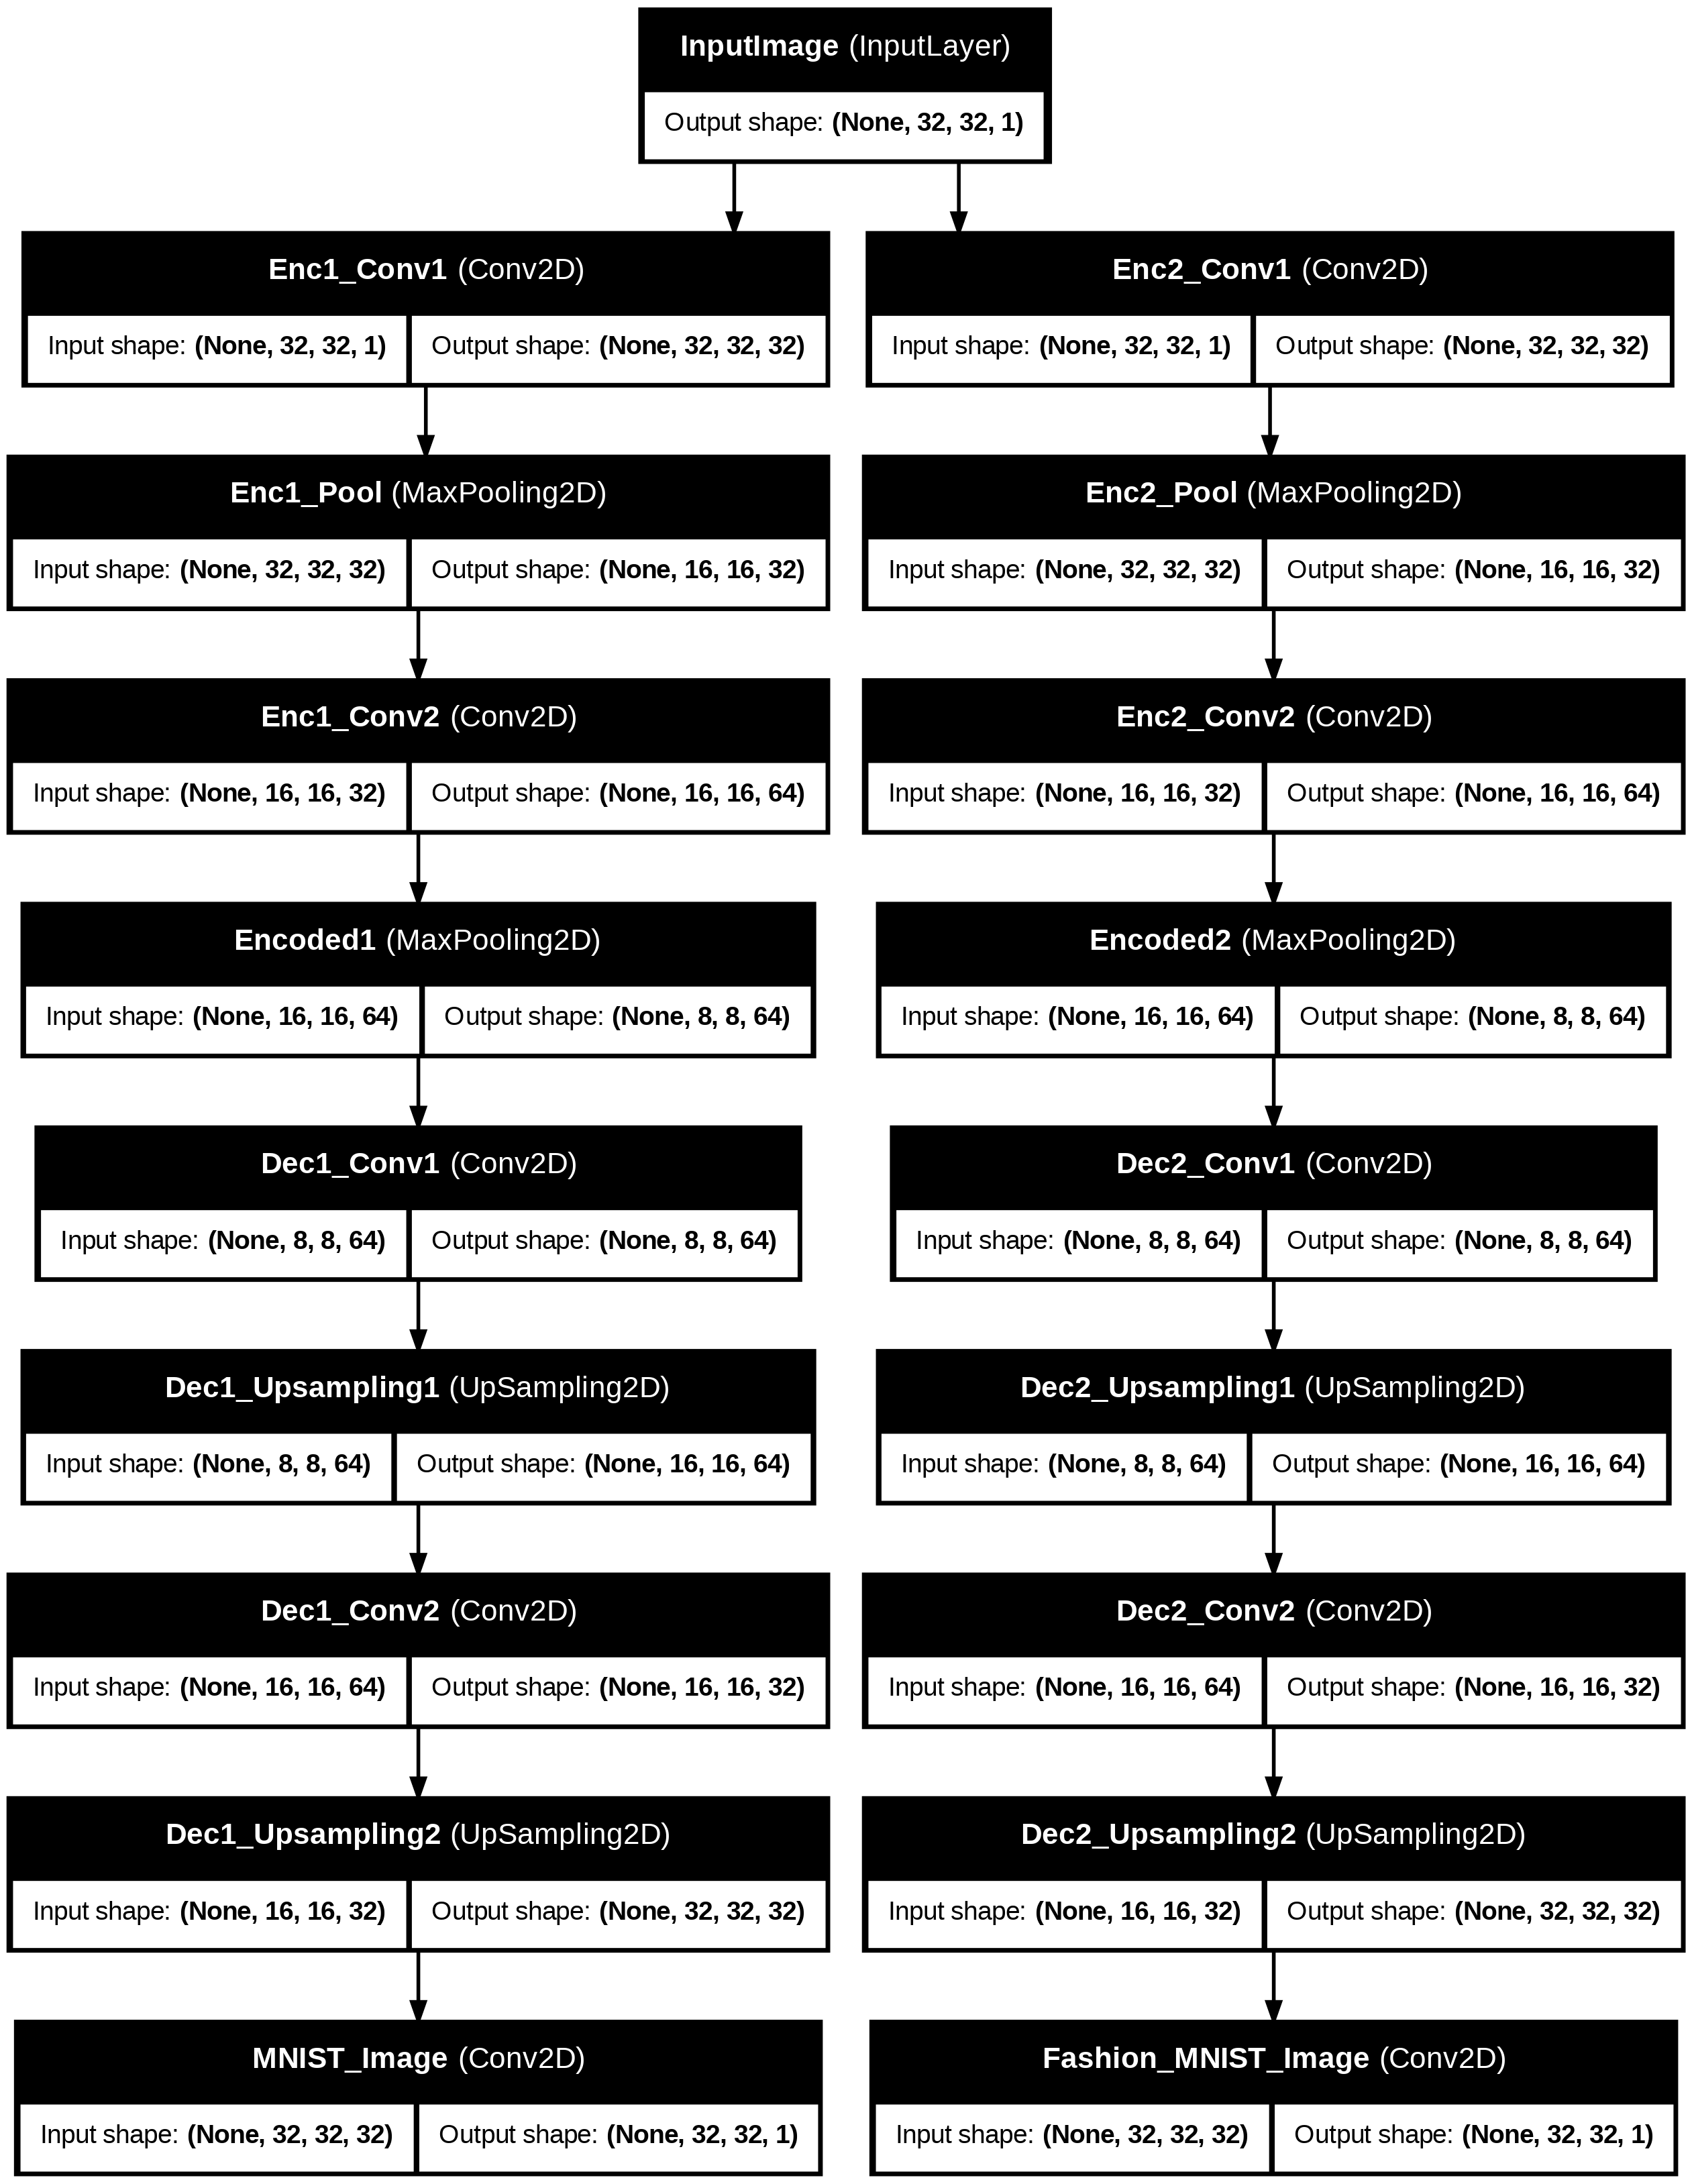

In [19]:
keras.utils.plot_model(model, "model.png", show_shapes = True, show_layer_names = True)

Definisco la funzione di costo che l'addestramento minimizzerà il più possibile.

In [20]:
mse_loss = keras.losses.MeanSquaredError(
    reduction = "sum_over_batch_size",
    name = "mean_squared_error"
)

Compilo la rete.

In [21]:
model.compile(
    loss = [mse_loss, mse_loss],
    optimizer = keras.optimizers.AdamW(learning_rate = learning_rate),
)

Definisco una callback EarlyStopping. Essa valuta alla fine di ogni epoca la funzione di costo sul validation set e decide se fermare l'addestramento oppure no. Utile per stabilire automaticamente un buon numero di epoche di addestramento della rete.

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',   # Monitora la loss sulla metrica indicata
    min_delta = 0.001,      # Variazione minima da considerare come miglioramento
    patience = early_stopping_patience,          # Numero di epoche senza miglioramenti prima di fermare l'addestramento
    mode = 'auto',          # oppure prende "min", "max", seleziona la direzione in automatico
    restore_best_weights = True,  # Ripristina i pesi migliori quando l'addestramento si ferma
    start_from_epoch = 5    # Inizia il monitoraggio dall'epoca 5
)

Definisco una callback "BackupAndRestore".  
Alla fine di ogni epoca di addestramento, essa salva la rete in un file di backup temporaneo.  
Se il notebook dovesse bloccarsi a tempo di esecuzione, sarà possibile riavviare l'addestramento ripristinando l'ultimo stato salvato nel file di backup.

In [23]:
backup_and_restore = keras.callbacks.BackupAndRestore(backup_dir = "/tmp/backup")

Definisco una callback per il controllo del learning rate.

In [24]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    min_delta = 0.001,
    factor = 0.2,
    patience = reduce_lr_patience,
    min_lr = 0.001
)

Addestro la rete.

In [25]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val), callbacks = [early_stopping, backup_and_restore, reduce_lr])

Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 1382s 17s/step - Fashion_MNIST_Image_loss: 0.1250 - MNIST_Image_loss: 0.0968 - loss: 1.0258 - val_Fashion_MNIST_Image_loss: 0.0918 - val_MNIST_Image_loss: 0.0855 - val_loss: 0.2916 - learning_rate: 0.0100
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 1398s 17s/step - Fashion_MNIST_Image_loss: 0.0854 - MNIST_Image_loss: 0.0856 - loss: 0.2873 - val_Fashion_MNIST_Image_loss: 0.0768 - val_MNIST_Image_loss: 0.0855 - val_loss: 0.2698 - learning_rate: 0.0100
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 1398s 17s/step - Fashion_MNIST_Image_loss: 0.0769 - MNIST_Image_loss: 0.0858 - loss: 0.2706 - val_Fashion_MNIST_Image_loss: 0.0755 - val_MNIST_Image_loss: 0.0855 - val_loss: 0.2671 - learning_rate: 0.0100
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 1370s 17s/step - Fashion_MNIST_Image_loss: 0.0759 - MNIST_Image_loss: 0.0855 - loss: 0.2677 - val_Fashion_MNIST_Image_loss: 0.0752 - val_MNIST_Image_loss: 0.0855 - val_loss: 0.2688 - learning_rate: 0.0100
Epoch 5/15
79/79 ━━━━━━━━━━━

Ora definisco una funzione per la creazione di grafici della storia del training e visualizzo due grafici che la mostrano.

dict_keys(['Fashion_MNIST_Image_loss', 'MNIST_Image_loss', 'loss', 'val_Fashion_MNIST_Image_loss', 'val_MNIST_Image_loss', 'val_loss', 'learning_rate'])


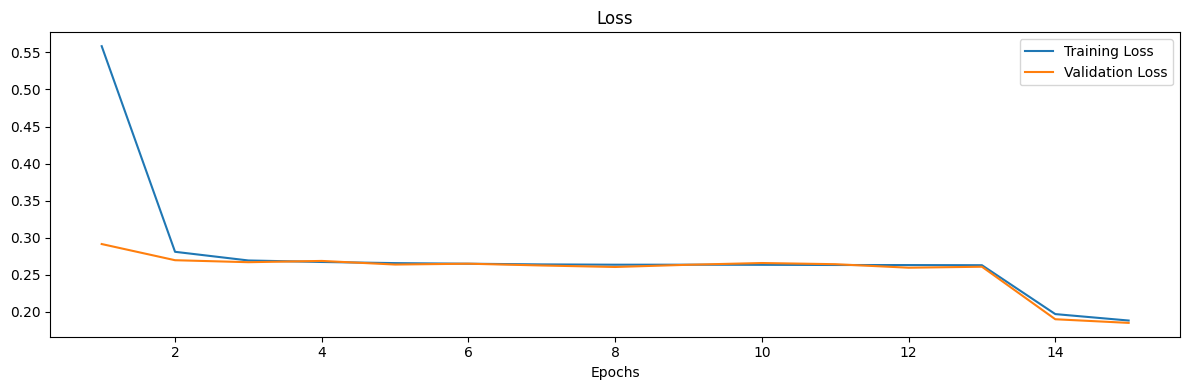

In [26]:
print(history.history.keys())

def plot_training_history(history):

    # Estrai la loss di training e le due accuracy di validation, una per ogni output
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Crea un grafico
    epochs = range(1, len(training_loss) + 1)
    plt.figure(figsize=(12, 4))

    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Definisco due funzioni per la valutazione finale del modello.

In [27]:
def eval_model(model):
  x, (y1, y2) = next(testgen)
  if isinstance(model, keras.Model):
    pred1, pred2 = model.predict(x)
  else:
    pred1, pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

def multiple_eval_model(model, repeat_eval = 10):
  eval_results = []
  for i in range(repeat_eval):
    eval_results.append(eval_model(model))
  print("mse mean = ", np.mean(eval_results))
  print("mse standard deviation = ", np.std(eval_results))

Valuto la rete e il modello casuale e confronto le loro prestazioni.  
Più questi valori sono vicini a zero, più la rete è accurata.

In [28]:
print('Valutazione modello banale')
multiple_eval_model(ide_model)

print('Valutazione rete neurale')
multiple_eval_model(model)

Valutazione modello banale
mse mean =  0.05444620376207469
mse standard deviation =  0.00024331034819212452
Valutazione rete neurale
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step
mse mean =  0.12427805628777663
mse standard deviation =  0.0006245489632537387


Mostriamo alcuni esempi

Primo campione di esempio


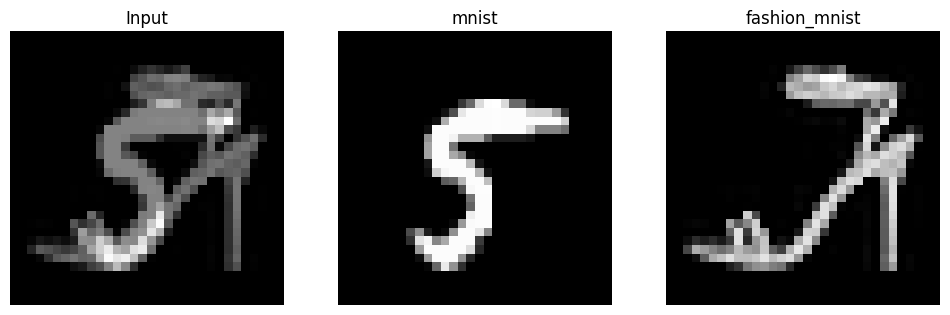

Previsione del modello banale


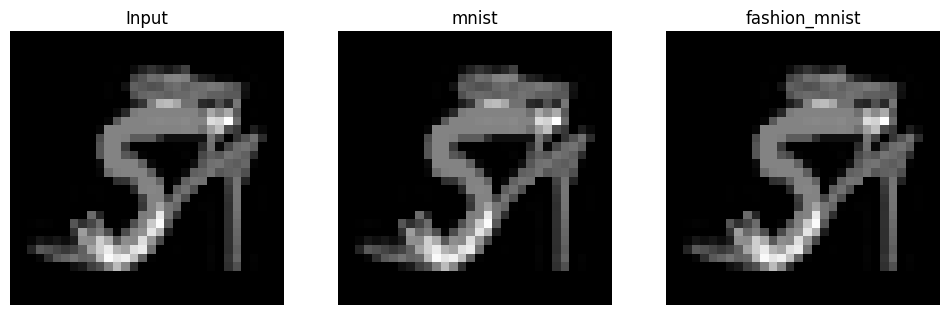

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


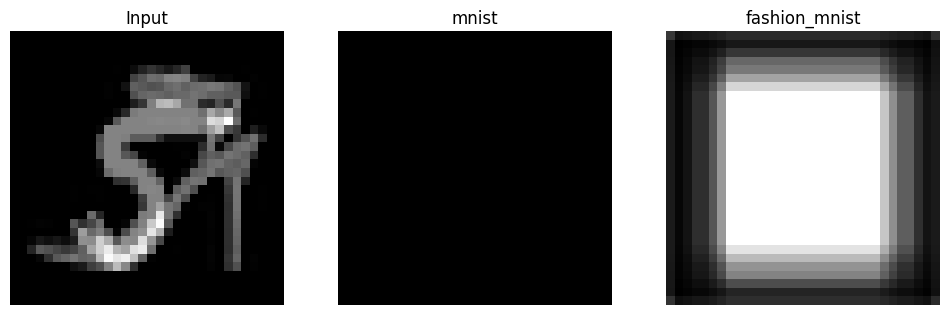



Secondo campione di esempio


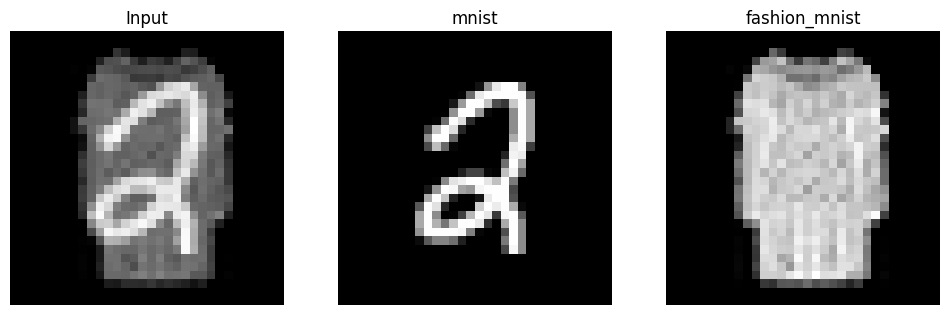

Previsione del modello banale


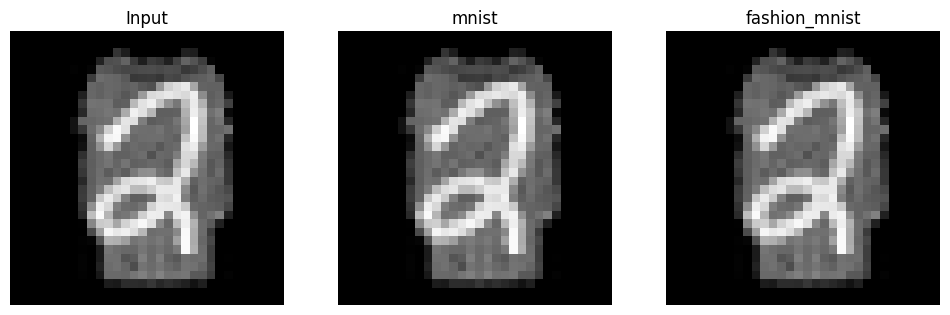

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


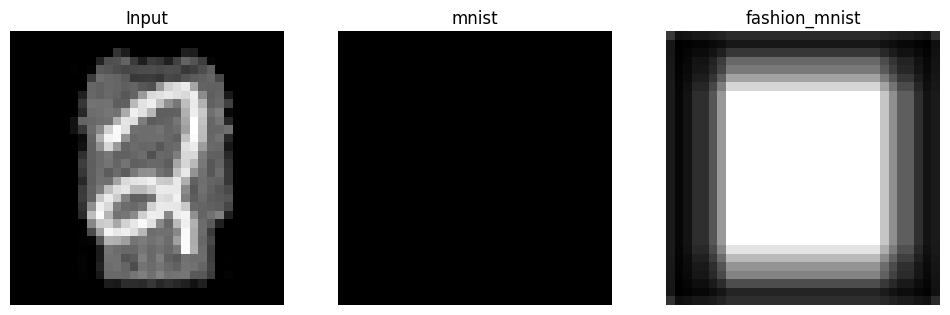



Terzo campione di esempio


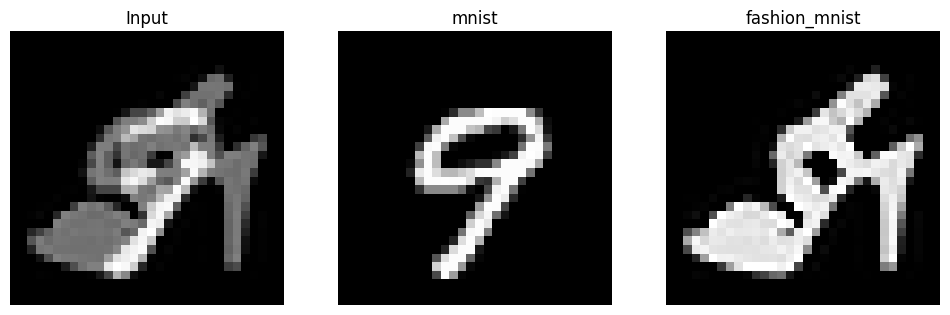

Previsione del modello banale


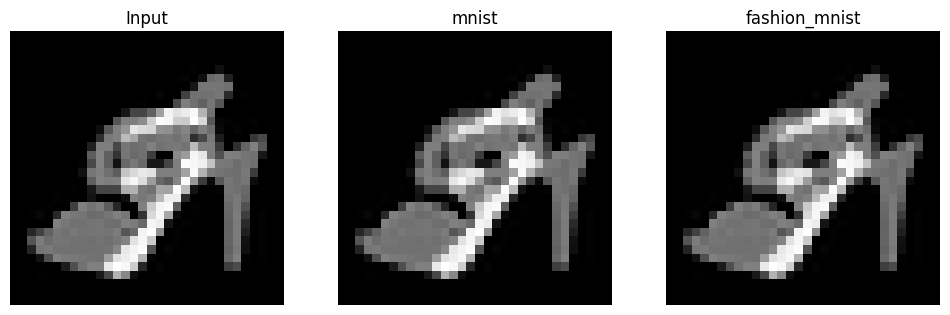

Previsione della rete neurale
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


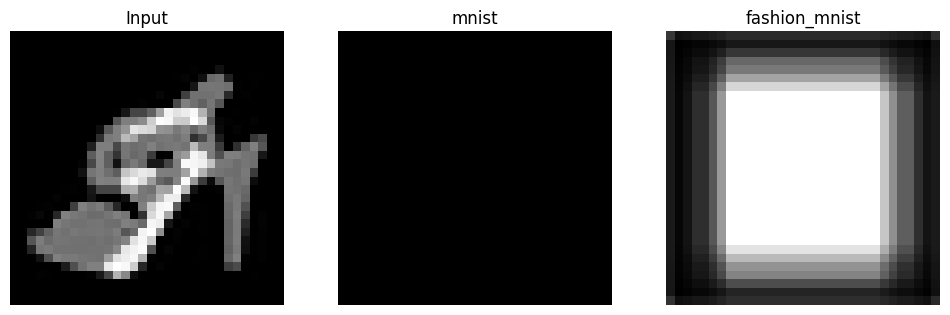

In [29]:
onegen = datagenerator(mnist_x_test, fashion_mnist_x_test, 1)

def show_images(x, y1, y2):
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

print('Primo campione di esempio')
x, (y1, y2) = next(onegen)
show_images(x[0], y1[0], y2[0])

print('Previsione del modello banale')
y1_pred, y2_pred = ide_model(x)
show_images(x[0], y1_pred[0], y2_pred[0])

print('Previsione della rete neurale')
y1_pred, y2_pred = model.predict(x)
show_images(x[0], y1_pred[0], y2_pred[0])

print()
print()

print('Secondo campione di esempio')
x, (y1, y2) = next(onegen)
show_images(x[0], y1[0], y2[0])

print('Previsione del modello banale')
y1_pred, y2_pred = ide_model(x)
show_images(x[0], y1_pred[0], y2_pred[0])

print('Previsione della rete neurale')
y1_pred, y2_pred = model.predict(x)
show_images(x[0], y1_pred[0], y2_pred[0])

print()
print()

print('Terzo campione di esempio')
x, (y1, y2) = next(onegen)
show_images(x[0], y1[0], y2[0])

print('Previsione del modello banale')
y1_pred, y2_pred = ide_model(x)
show_images(x[0], y1_pred[0], y2_pred[0])

print('Previsione della rete neurale')
y1_pred, y2_pred = model.predict(x)
show_images(x[0], y1_pred[0], y2_pred[0])